<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/Exploration/%EB%89%B4%EC%8A%A4/%EB%89%B4%EC%8A%A4_%EC%9A%94%EC%95%BD%EB%B4%87__%EB%A7%8C%EB%93%A4%EA%B8%B0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# Data Load

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
df_news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
df_news.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


(array([1.0000e+00, 1.4000e+01, 1.4840e+03, 5.4910e+03, 4.1551e+04,
        4.1213e+04, 6.3630e+03, 2.2060e+03, 7.7000e+01, 1.0000e+00]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

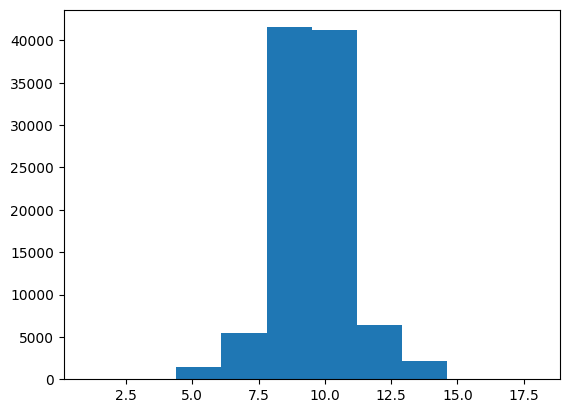

In [6]:
# headline length
plt.hist(df_news.headlines.apply(lambda x : len(x.split())))

In [7]:
df_news.headlines[df_news.headlines.apply(lambda x : len(x.split())) < 4]

52                                 headlines
729      Angola decriminalises homosexuality
26212     What is 'Friggatriskaidekaphobia'?
Name: headlines, dtype: object

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+01,
        8.7610e+03, 8.9576e+04, 2.2000e+01, 0.0000e+00, 1.0000e+00]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

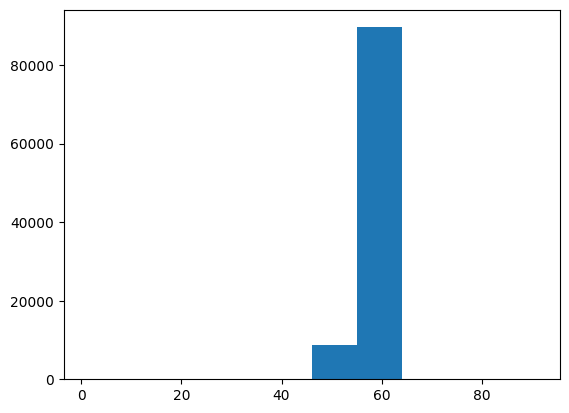

In [8]:
# text length
plt.hist(df_news.text.apply(lambda x : len(x.split())))

In [9]:
df_news.text[df_news.text.apply(lambda x : len(x.split())) < 40]

52                                                    text
26536    Live-stream videos, stay connected and do much...
Name: text, dtype: object

- 불용어 제거 진행 한후에 다시 Word Length 를 비교 해 보도록 하자.

# Data Preprocessing

## 중복 문장(Sentence) 제거

In [10]:
print('Text 열 샘플 수 : ', len(df_news['text']))
print('Text 열에서 중복을 배제한 유일한 샘플 수 : ', df_news['text'].nunique())
print('Headline 열 샘플 수 : ', len(df_news['headlines']))
print('Headline 열에서 중복을 배제한 유일한 샘플 수 : ', df_news['headlines'].nunique())

Text 열 샘플 수 :  98401
Text 열에서 중복을 배제한 유일한 샘플 수 :  98360
Headline 열 샘플 수 :  98401
Headline 열에서 중복을 배제한 유일한 샘플 수 :  98280


In [11]:
# remove duplicate
df_ddup = df_news.drop_duplicates(subset=['text'])
print('전체 샘플수 ' , len(df_ddup))

전체 샘플수  98360


In [12]:
print(df_ddup.isnull().sum())

headlines    0
text         0
dtype: int64


# Text normalization & 불용어 처리
정규화 사전 참조 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [13]:
# contraction
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

- 정규화 이전에 불용어(stopwords)부터 처리 한다.

In [14]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- Summary를 입력으로 할 때는 두번째 인자를 0으로 줘서 불용어를 제거하지 않는 버전을 실행하겠습니다.

In [15]:
# 전처리 함수 Test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [16]:
# Text 열 전처리
clean_text = []
for s in df_ddup['text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [17]:
# headline 열 전처리
clean_headline = []
for s in df_ddup['headlines']:
    clean_headline.append(preprocess_sentence(s, 0))
clean_headline[:5]

<ipython-input-14-d6fde676e422>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [18]:
df_ddup.loc[:,'text'] = clean_text
df_ddup.loc[:,'headlines'] = clean_headline

<ipython-input-18-6871f5da5872>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ddup.loc[:,'text'] = clean_text
<ipython-input-18-6871f5da5872>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ddup.loc[:,'headlines'] = clean_headline


In [19]:
# 길이가 공백인 샘플은 NULL 값으로 변환
df_ddup.replace('', np.nan, inplace=True)
print(df_ddup.isnull().sum())

headlines    0
text         0
dtype: int64


<ipython-input-19-0437526a3d2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ddup.replace('', np.nan, inplace=True)


- 다행히도 null값이 존재 하지 않는다 .

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
제목의 최소 길이 : 1
제목의 최대 길이 : 16
제목의 평균 길이 : 9.299532330215534


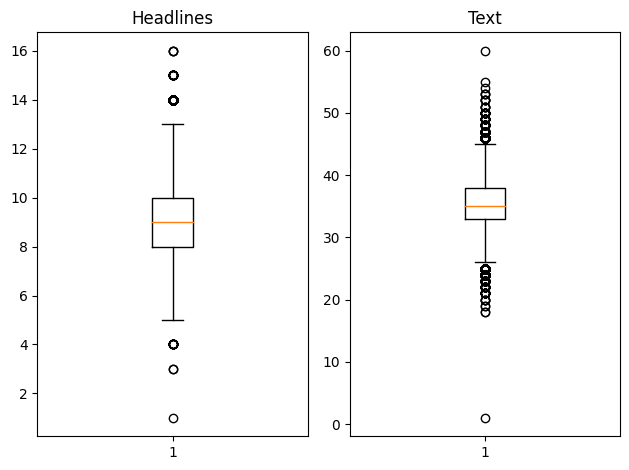

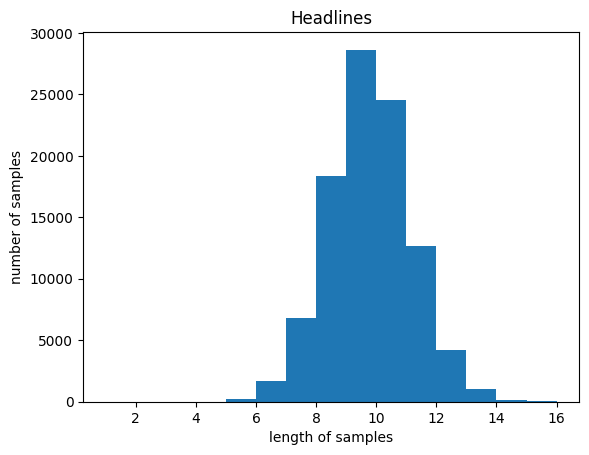

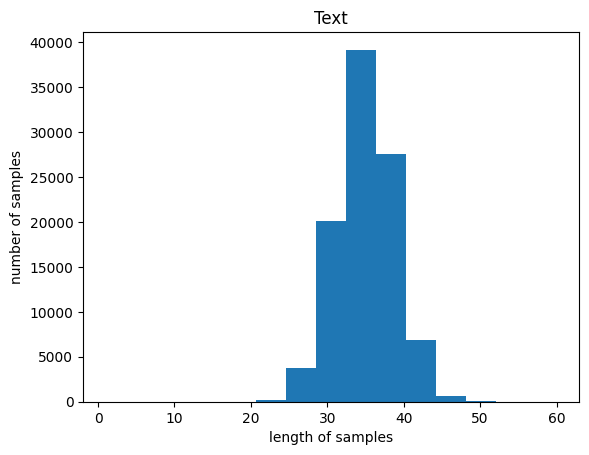

In [20]:
# 길이(단어) 분포 출력
text_len = [len(s.split()) for s in df_ddup['text']]
headline_len = [len(s.split()) for s in df_ddup['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headline_len)))
print('제목의 최대 길이 : {}'.format(np.max(headline_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headline_len , bins = 15)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len , bins = 15)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
percentile = 99
print(f' Text 에서 비율이 {percentile}% 인 길이 : {np.percentile(text_len , percentile)}')

 Text 에서 비율이 99% 인 길이 : 44.0


In [22]:
df_ddup.text[df_ddup.text.apply(lambda x : len(x.split())) > 44]

1        kunal shah credit card bill payment platform c...
82       sri lanka rounder thisara perera written sri l...
110      congress president rahul gandhi recent poll pr...
248      us writer claimed billionaire ex starbucks ceo...
256      popular period tracking apps selling women pri...
                               ...                        
96987    reacting photograph ranveer singh wearing whit...
97125    nasa developed deep space atomic clock provide...
98138    apollo tyres introduced latest th generation r...
98283    us based study claimed mammal body size could ...
98362    man killed malaysia airport last month confirm...
Name: text, Length: 652, dtype: object

In [23]:
percentile = 1
print(f' Text 에서 비율이 {percentile}% 인 길이 : {np.percentile(text_len , percentile)}')

 Text 에서 비율이 1% 인 길이 : 26.0


In [24]:
df_ddup.text[df_ddup.text.apply(lambda x : len(x.split())) < 26]

52                                                    text
53       oneplus emerged india best selling premium sma...
179      india ranked corruption perceptions index rele...
341      speaking government program west bengal chief ...
460      union minister anantkumar hegde sunday said ha...
                               ...                        
97049    indian cricketing legend sachin tendulkar thur...
97411    actress taapsee pannu revealed wanted slap peo...
97851    rape victim reportedly asked pay fine leaders ...
97910    filmmaker karan johar said mother twin childre...
98105    actress priyanka chopra said dna feel insecure...
Name: text, Length: 563, dtype: object

In [25]:
percentile = 99
print(f' headline 에서 비율이 {percentile}% 인 길이 : {np.percentile(headline_len , percentile)}')

 headline 에서 비율이 99% 인 길이 : 13.0


In [26]:
df_ddup.headlines[df_ddup.headlines.apply(lambda x : len(x.split())) > 13]

83       do not use visit to ailing man for political g...
142      you want ganga clean also wash sins in it thar...
160      us thieves try to steal tv return it as it did...
161      man goes to bank in spider man costume on last...
191      up cm yogi takes holy dip in ganga post cabine...
                               ...                        
67816    do not want sorry you are not in sari tamil ac...
79166    we are not made of sugar we will not melt puti...
85462    katrina is my jaan but that is not the title o...
88963    my mom wanted to poison me but today she is pr...
91716    will not take up any post in cong for yr maken...
Name: headlines, Length: 180, dtype: object

In [27]:
percentile = 1
print(f' headline 에서 비율이 {percentile}% 인 길이 : {np.percentile(headline_len , percentile)}')

 headline 에서 비율이 1% 인 길이 : 6.0


In [28]:
df_ddup.headlines[df_ddup.headlines.apply(lambda x : len(x.split())) < 6]

52                                       headlines
264      nagaland cabinet rejects citizenship bill
729            angola decriminalises homosexuality
1091            mexico registers record murders in
2966         rwanda bans skin lightening cosmetics
                           ...                    
97436       herring fish communicate through farts
97679         nit warangal student commits suicide
97691         italy named world healthiest country
97704           underwater treasure found in china
98000                how does virtual reality work
Name: headlines, Length: 242, dtype: object

- Text 와 headline 에서 너무 길거나 짧은 문장들은 제거 하겠습니다.

텍스트 전처리에서 너무 짧거나 긴 문장들을 제거하는 이유는 주로 다음과 같습니다:

1. 모델 성능 향상: 텍스트 데이터를 처리하는 자연어 처리 모델은 주로 시퀀스 데이터를 다루는데, 너무 짧은 문장은 충분한 정보를 담고 있지 않을 수 있고, 너무 긴 문장은 모델이 처리하기 어려울 수 있습니다. 따라서 적절한 길이의 문장들로 구성된 데이터를 사용하는 것이 모델의 성능 향상에 도움이 됩니다.

2. 계산 효율성: 너무 긴 문장들은 모델 학습 및 예측 시에 계산 비용이 많이 들어갈 수 있습니다. 특히, GPU 또는 TPU와 같은 하드웨어 가속기를 사용하여 모델을 학습하는 경우에는 긴 문장들을 처리하는데 더 많은 메모리와 계산 자원이 필요하므로, 이를 줄이기 위해 긴 문장들을 제거하거나 적절히 분할하는 것이 유용합니다.

3. 일반화 능력 향상: 너무 짧은 문장들은 훈련 데이터에서는 잘 동작할지 몰라도 실제 응용 시에는 일반화 능력이 떨어질 수 있습니다. 짧은 문장들은 문맥이 부족하여 모델이 올바른 판단을 내리기 어렵습니다. 반면에 너무 긴 문장들은 불필요한 정보를 포함할 가능성이 높아 모델의 성능을 저하시킬 수 있습니다.

4. 데이터 품질 향상: 텍스트 데이터의 품질은 모델의 학습에 중요한 영향을 미칩니다. 따라서 너무 짧거나 긴 문장들을 제거하여 데이터의 일관성과 질을 향상시키는데 도움이 됩니다

- 따라서, 적절한 길이의 문장들로 구성된 데이터를 사용하면 모델의 성능과 효율성을 향상시킬 수 있습니다. 이를 위해서는 데이터 전처리 과정에서 문장들의 길이를 조절하는 방법을 적용하거나, 일정 길이 이상 또는 이하의 문장들을 제거하는 등의 작업이 필요합니다.

In [29]:
df_filtered = df_ddup[df_ddup.text.apply(lambda x: 26 < len(x.split()) < 44) &
                        df_ddup.headlines.apply(lambda x: 6 < len(x.split()) < 13) ]
print('전체 샘플수 :',(len(df_filtered)))

전체 샘플수 : 92901


In [30]:
df_filtered.sample(10)

,headlines,text
13694,eng cricketers vehicle gets stuck in mud on sa...,vehicle carrying england cricketers including ...
24781,who is rohit prasad the indian engineer behind...,india born engineer rohit prasad spearheaded d...
40757,man held with kg ganja in snack packets at lur...,year old passenger arrested bengaluru airport ...
78360,woman demands death penalty for man who killed...,woman guwahati lodged police complaint neighbo...
29003,shimla residents stage midnight protest over w...,residents shimla staged sit protest outside wa...
86353,afridi picks tendulkar akram in his dream odi xi,former pakistani captain shahid afridi picked ...
8405,indonesia plane nosedived times in minutes bef...,black box data crashed indonesian lion air fli...
20812,video chopper lands on roof to rescue kerala f...,video indian navy seaking helicopter landing r...
54606,pm modi offers condolences to kin of mumbai fi...,expressing condolence death people fire mumbai...
22948,russia appoints actor steven seagal as special...,russian foreign ministry appointed hollywood a...


## Token 추가
- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다.
- 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 명명하고 앞, 뒤로 추가하겠습니다.

In [31]:
# headline data Token 추가.
df_filtered['decoder_input'] = df_filtered['headlines'].apply(lambda x : 'sostoken '+ x)
df_filtered['decoder_target'] = df_filtered['headlines'].apply(lambda x : x + ' eostoken')
df_filtered.head()

<ipython-input-31-d155c2493a60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['decoder_input'] = df_filtered['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-31-d155c2493a60>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['decoder_target'] = df_filtered['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


## 인코더의 입력, 디코더의 입력과 레이블 저장.

In [32]:
encoder_input = np.array(df_filtered['text'])
decoder_input = np.array(df_filtered['decoder_input'])
decoder_target = np.array(df_filtered['decoder_target'])

## 데이터 분리

- Shuffle

In [33]:
indices = np.arange(encoder_input.shape[0])
print(indices)
np.random.shuffle(indices)
print(indices)

[    0     1     2 ... 92898 92899 92900]
[59546 84458   941 ...  3064 52043  6175]


In [34]:
# data Shuffle
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 8:2 비율로 분리 (Train : Test )

In [35]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18580


In [77]:
# 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 74321
훈련 레이블의 개수 : 74321
테스트 데이터의 개수 : 18580
테스트 레이블의 개수 : 18580


## 정수 인코딩

정수 인코딩 과정은 보통 다음과 같은 단계로 이루어집니다:

- 토큰화(Tokenization): 텍스트를 단어 또는 의미 단위로 나누는 토큰화 과정을 수행합니다. 이때, 단어 또는 의미 단위로 분리된 각각의 단위를 "토큰"이라고 합니다.

- 빈도수 계산: 토큰화된 단어들의 빈도수를 계산합니다. 즉, 각 단어가 텍스트 내에서 얼마나 자주 등장하는지를 측정합니다.

- 정수 인덱스 매핑: 각 단어에 고유한 정수 인덱스를 부여합니다. 이때, 빈도수가 높은 단어에는 낮은 인덱스가 부여되는 경우가 많습니다. 이렇게 인덱스를 부여하는 것을 "정수 인코딩"이라고 합니다.

###  Vocaburary (text)

In [78]:
# Token 화
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

- 단어의 빈도수는 5회로 테스트 한다.

In [80]:
# 빈도수 계산
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67413
등장 빈도가 4번 이하인 희귀 단어의 수: 41801
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25612
단어 집합에서 희귀 단어의 비율: 62.007327963449185
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.731747368469471


In [81]:
# Vocab 생성 - 히귀 단어를 제외시킨 단어 집합.
src_vocab = 25612
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoder_input_train[:3])

[[205, 484, 264, 422, 963, 6537, 18928, 182, 1046, 3990, 3990, 1608, 1, 2478, 102, 1046, 182, 1046, 25, 1914, 1, 205, 6297, 118, 118, 2222, 3079, 3168, 2311, 953, 25], [159, 18, 187, 20081, 2832, 1277, 622, 1576, 4088, 534, 18, 239, 611, 61, 248, 16212, 419, 256, 20082, 54, 1576, 5321, 685, 157, 1542, 377, 18, 1, 622, 1576, 82, 2584, 2083, 4088, 534], [520, 132, 6538, 704, 35, 257, 438, 163, 59, 1432, 37, 8107, 4766, 1, 35, 12549, 3538, 94, 192, 132, 447, 1077, 23308, 292, 115, 6642, 17, 115, 4088, 3207, 35, 115, 56, 37, 56, 115, 4766, 4]]


###  Vocaburary (headline)

In [82]:
# Token 화
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [84]:
# 빈도수 계산
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29415
등장 빈도가 3번 이하인 희귀 단어의 수: 16636
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12779
단어 집합에서 희귀 단어의 비율: 56.55617882032976
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2837938643394073


In [85]:
# Vocab 생성 - 회귀 단어를 제외시킨 단어 집합
tar_vocab = 12779
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 확인
print(decoder_input_train[:5])
print(decoder_target_train[:5])

[[1, 288, 105, 1600, 611, 1987, 348, 611, 132, 2023], [1, 186, 78, 62, 10164, 8, 528, 6, 1575, 2051, 4, 18, 2052], [1, 215, 3548, 19, 112, 9275, 73, 1690, 32], [1, 98, 1691, 53, 8556, 271, 5, 30], [1, 19, 1314, 4392, 331, 128, 10, 2812, 3448, 4, 646]]
[[288, 105, 1600, 611, 1987, 348, 611, 132, 2023, 2], [186, 78, 62, 10164, 8, 528, 6, 1575, 2051, 4, 18, 2052, 2], [215, 3548, 19, 112, 9275, 73, 1690, 32, 2], [98, 1691, 53, 8556, 271, 5, 30, 2], [19, 1314, 4392, 331, 128, 10, 2812, 3448, 4, 646, 2]]


## Null 제거

In [86]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


- Null 값이 관측 되지 않았다.

In [87]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74321
훈련 레이블의 개수 : 74321
테스트 데이터의 개수 : 18580
테스트 레이블의 개수 : 18580


## Padding

In [89]:
# text 길이는 44 미만  , headline 길이는 13 미만.
text_maxlen = 44
headline_maxlen = 13

# Encoder
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_maxlen, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_maxlen, padding='post')

# Decoder
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_maxlen, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_maxlen, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_maxlen, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_maxlen, padding='post')

# Model Build
- seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [90]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau
import tensorflow as tf

In [91]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [92]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [93]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 44)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 44, 128)      3278336     ['input_11[0][0]']               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 44, 256),    394240      ['embedding_4[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 어텐션 Layer

In [94]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 44)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 44, 128)      3278336     ['input_11[0][0]']               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 44, 256),    394240      ['embedding_4[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [95]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min')
checkpoint = ModelCheckpoint("cr4_explo_summary.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [early_stopping, reduce_lr , checkpoint]

In [96]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy')

In [97]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=callbacks, epochs = 100)

Epoch 1/100
291/291 [==============================] - ETA: 0s - loss: 5.6839
Epoch 1: val_loss improved from inf to 5.35328, saving model to cr4_explo_summary.h5
291/291 [==============================] - 65s 200ms/step - loss: 5.6839 - val_loss: 5.3533 - lr: 0.0010
Epoch 2/100
291/291 [==============================] - ETA: 0s - loss: 5.3610
Epoch 2: val_loss improved from 5.35328 to 5.27224, saving model to cr4_explo_summary.h5
291/291 [==============================] - 38s 131ms/step - loss: 5.3610 - val_loss: 5.2722 - lr: 0.0010
Epoch 3/100
291/291 [==============================] - ETA: 0s - loss: 5.2800
Epoch 3: val_loss improved from 5.27224 to 5.18921, saving model to cr4_explo_summary.h5
291/291 [==============================] - 38s 131ms/step - loss: 5.2800 - val_loss: 5.1892 - lr: 0.0010
Epoch 4/100
291/291 [==============================] - ETA: 0s - loss: 5.2029
Epoch 4: val_loss improved from 5.18921 to 5.11251, saving model to cr4_explo_summary.h5
291/291 [============

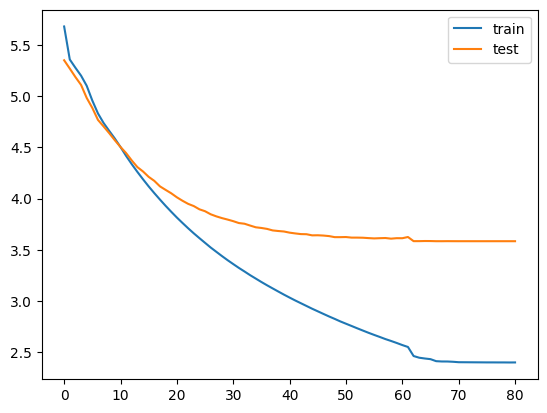

In [99]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 요약 모델 테스트 하기

In [100]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [101]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [102]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_maxlen, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [103]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # 에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_maxlen-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [104]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i == 'eostoken' or i == 0):  # 종료 토큰(eostoken)이 나오거나 패딩 토큰(0)을 만나면 종료
            break
        if i != 'sostoken':  # 시작 토큰(sostoken)이 아닌 경우에만 추가
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [181]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_maxlen)))
    print("\n")

원문 : national award winning actor adil hussain said films pay bills films dil aiyaary small roles pay bills films like mukti bhawan pay added adil said good right time first passion theatre 
실제 요약 : sostoken do some films for bill some for dil hussain 
1/1 [==============================] - 0s 35ms/step
예측 요약 :  will not return to my life if you are not rajinikanth


원문 : rcb captain virat kohli applauded trent boult catch inches away boundary said feel bad getting catch like adding good fans best catch ever seen unbelievable left hander grabbed right hand gautam gambhir said 
실제 요약 : you do not feel bad getting out to catch like that kohli 
1/1 [==============================] - 0s 26ms/step
예측 요약 :  kohli takes catch to bat after his catch


원문 : us president donald trump japanese prime minister shinzo abe confirmed phone talks increase pressure north korea nuclear ballistic missile threats comes trump said china tried failed help north korea working develop nuclear tipped missile ca

In [208]:
original = []
real = []
predict = []
for i in range(0, 50):
    original.append(seq2text(encoder_input_test[i]))
    real.append(seq2summary(decoder_input_test[i]))
    predict.append(decode_sequence(encoder_input_test[i].reshape(1, text_maxlen)))


1/1 [==============================] - 0s 39ms/step


In [187]:
df = pd.DataFrame({'원문':original , '실제요약':real, '예측' : predict})
df

,원문,실제요약,예측
0,national award winning actor adil hussain said...,sostoken do some films for bill some for dil h...,will not return to my life if you are not raj...
1,rcb captain virat kohli applauded trent boult ...,you do not feel bad getting out to catch like ...,kohli takes catch to bat after his catch
2,us president donald trump japanese prime minis...,sostoken us japan to increase pressure on nort...,trump to build japan in korea to north korea
3,former indian captain sourav ganguly feels bow...,sostoken without bumrah india bowling attack i...,rahane should be the best test bowler to ganguly
4,year old man identified arrested sexually assa...,yr old man sexually assaults yr old girl in ta...,man arrested for raping minor girl in yr old ...
5,online marketplace automobiles droom raised mi...,sostoken portal raises mn in series funding,co founder raises million in series funding
6,rajasthan police arrested year old visually im...,sostoken visually impaired man hires men to ro...,man held for beating up police officer for mo...
7,arsenal failed qualify uefa champions league f...,sostoken arsenal fail to qualify for champions...,sindhu beats arsenal to win th straight win t...
8,former india cricketer virender sehwag claimed...,did not get coach job since did not have any s...,bcci should be given to prove my income tax s...
9,central board secondary education barred aspir...,sostoken aspirants not allowed to wear shoes h...,du college to wear dress dress for girls


In [207]:
df.원문[3] , df.실제요약[3] , df.예측[3]

('former indian captain sourav ganguly feels bowling attack without pacer jasprit bumrah weak bumrah different effect test series shami feel good bowler however new bowling attack odis ganguly said india set face australia second odi tuesday ',
 'sostoken without bumrah india bowling attack is weak ganguly ',
 ' rahane should be the best test bowler to ganguly')

# Extractive 요약

In [106]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=24f340bb6a1db5d445dfa6b0ee6b2b0bd4b4e88afd3bec9a6fba9d45ebc82a62
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [169]:
from summa.summarizer import summarize
import requests

In [198]:
# summarize
texts=[]
summarized_texts = []
for text in df_news.text[:50]:
  summarized_text = summarize(str(text), words = 10)
  texts.append(text)
  summarized_texts.append(summarized_text)

df_summa = pd.DataFrame({'원문':texts , '예측' : summarized_texts})
df_summa



,원문,예측
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Kunal Shah's credit card bill payment platform...,
2,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,"With Aegon Life iTerm Insurance plan, customer...",
4,Speaking about the sexual harassment allegatio...,
5,Pakistani singer Rahat Fateh Ali Khan has deni...,
6,India recorded their lowest ODI total in New Z...,India's previous lowest ODI total in New Zeala...
7,Weeks after ex-CBI Director Alok Verma told th...,
8,Andhra Pradesh CM N Chandrababu Naidu has said...,
9,Congress candidate Shafia Zubair won the Ramga...,


In [209]:
df_summa.원문[42] , df_summa.예측[42]

('Micro-blogging platform Twitter is testing a new feature on Android to put news on the top of a user\'s timeline. "With this update, weÃ¢Â\x80Â\x99re making it easier for people to see news and stories their followers have been discussing," Product Manager Walter Gurzynski said. The feature comes alongside a prompt saying, "Catch up on what\'s happened while you were away."',
 "Micro-blogging platform Twitter is testing a new feature on Android to put news on the top of a user's timeline.")

### 회고

1. 1st Model Train
 - 빈도수 : text 9  , headline 8
 - 학습률 : 0.0001 , epoch : 50
 - val_loss : 5.8
 - 학습이 제대로 안되고 끝난 느낌이었다. 결과는 아래와 같이 나왔다

 - 원문 : man named douglas trolled people festival canada selling hot dog water per bottle water used cook hot dogs advertised man health product could help people lose weight part social experiment encourage critical thinking related product marketing
 - 실제 요약 : sostoken man trolls people with hot dog water costing bottle
 - 예측 요약 :  trump to be trump to be trump


 - 원문 : andhra pradesh enjoying double digit growth since bifurcation telangana state finance minister said tuesday andhra grew rate grew first half asserted per capita income less per capita income grow employment opportunities increase said
 - 실제 요약 : sostoken andhra double growth post division minister
 - 예측 요약 :  govt to be to be in not sc

 - 우영우 같은 요약들이 되어 버렸다. 희귀 단어들의 빈도수를 너무 높여서 그런것인지 아니면 , 고민 했던 것 처럼 학습이 미리 종료 되버려서 이런 결과가 나온건지 애매한 판단이 되었다.


2. 2nd Model Train
 - 빈도수 : text 4  , headline 3
 - 학습률 : 0.001 , epoch : 100 (81epoch 조기 종료)
 - val_loss : 3.58

 - 1st train 에 비해서 훨씬 좋은 결과가 나왔다. 중요 단어들도 포함된 것으로 보이나 , 문맥상 좋은 요약은 아닌것 으로 판단된다.

 - 1st train 에 비해서 좋은 결과가 나온 이유에 대해서는 정확한 원인을 찾기는 어렵지만 학습률이 1st 에 비해서 잘 조절 되면서 마무리된 것으로 보인다.

3. 추상적 요약 VS 추출 요약
 - 추상적 요약은 글을 생성한 느낌.
 - 추출 요약은 원문이 가지고 있는 문장을 그대로 가져오는 느낌.